In [71]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../paretoviz')
from paretoviz import plotting as pplt
from paretoviz import decorator as dcor
from paretoviz.utils import fmt
from paretoviz.utils import vectorops as vops
from paretoviz.decorator import Arrow3D

# Do all these plots with centroid based coloring

# rawfpath = "../data/spherical/spherical-3d.out"
# rawfpath = "../data/spherical/spherical-4d.out"
# rawfpath = "../data/spherical/spherical-8d.out"

# rawfpath = "../data/knee/knee-3d.out"
# rawfpath = "../data/knee/knee-4d.out"
# rawfpath = "../data/knee/knee-8d.out"

# rawfpath = "../data/line-surface/line-3d.out"
rawfpath = "../data/line-surface/line-4d.out"
# rawfpath = "../data/line-surface/line-6d.out"
# rawfpath = "../data/line-surface/line-8d.out"

# rawfpath = "../data/carcrash/carcrash-3d.out"
# rawfpath = "../data/carcrash/carcrash-c1/carcrash-c1-3d.out"
# rawfpath = "../data/carcrash/carcrash-c2/carcrash-c2-3d.out"

# Do all these plots with constraint based coloring

# rawfpath = "../data/knee-const/knee-const-3d.out"
# rawfpath = "../data/knee-const/knee-const-4d.out"
# rawfpath = "../data/knee-const/knee-const-8d.out"

# rawfpath = "../data/knee-const-mod/knee-const-mod-3d.out"
# rawfpath = "../data/knee-const-mod/knee-const-mod-4d.out"

# rawfpath = "../data/isolated/isolated-3d.out"
# rawfpath = "../data/isolated/isolated-4d.out"
# rawfpath = "../data/isolated/isolated-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-4d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-5d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-c1/c2dtlz2-c1-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c2/c2dtlz2-c2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c3/c2dtlz2-c3-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c4/c2dtlz2-c4-3d.out"

# rawfpath = "../data/gaa-das/gaa-das-10d.out"
# rawfpath = "../data/gaa-lhs/gaa-lhs-10d.out"

# some ML data sets
# rawfpath = "../data/airofoil/airofoil-5d.out"
# rawfpath = "../data/banknote/banknote-4d.out"
# rawfpath = "../data/blood/blood-4d.out"
# rawfpath = "../data/cccp/cccp-4d.out"
# rawfpath = "../data/concrete/concrete-8d.out"
# rawfpath = "../data/iris/iris-4d.out"
# rawfpath = "../data/mammogram/mammogram-5d.out"
# rawfpath = "../data/wil/wil-7d.out"
# rawfpath = "../data/yeast/yeast-8d.out"

# do visualization based on distance from the centroid?
docentroid = False

# get the path and filename from the rawfpath
path, rawfile = os.path.split(rawfpath)
# get the prefix
prefix = rawfile.split('.')[0]

# load the normalized points
points = fmt.load(os.path.join(path, prefix + "-norm.out"))

# load the CV values
cvfpath = os.path.join(path, prefix + "-cv.out")
if not docentroid and os.path.exists(cvfpath):
    cv = [v[0] if len(v) == 1 else v for v in fmt.load(cvfpath)]
    [low, up] = vops.get_bound(cv)
    cv = vops.normalize(cv, low, up)
    color = dcor.recolor_by_cv(cv)
else:
    color = dcor.recolor_by_centroid(points)

# load the normalized trade-off values
mufpath = os.path.join(path, prefix + "-norm-mu.out")
knee_idx = None
if os.path.exists(mufpath):
    mu = [v[0] if len(v) == 1 else v for v in fmt.load(mufpath)]
    # resize the points w.r.t. trade-offs
    size = dcor.rescale_by_tradeoff(mu)
    (color, knee_idx) = dcor.recolor_by_tradeoff(size, color)

# load the class labels
classfpath = os.path.join(path, prefix + "-class.out")
if os.path.exists(classfpath):
    labels = [v[0] if len(v) == 1 else v for v in \
            fmt.load(classfpath, dtype = dcor.dtypes[prefix])]
    color = dcor.recolor_by_labels(labels, dtype = dcor.dtypes[prefix])
    size = [5.0 for _ in range(len(points))]

# alpha values
alpha = [0.2, 0.8] # alpha for plots with knee
# alpha = [1.0, 1.0] # alpha for general case

<IPython.core.display.Javascript object>


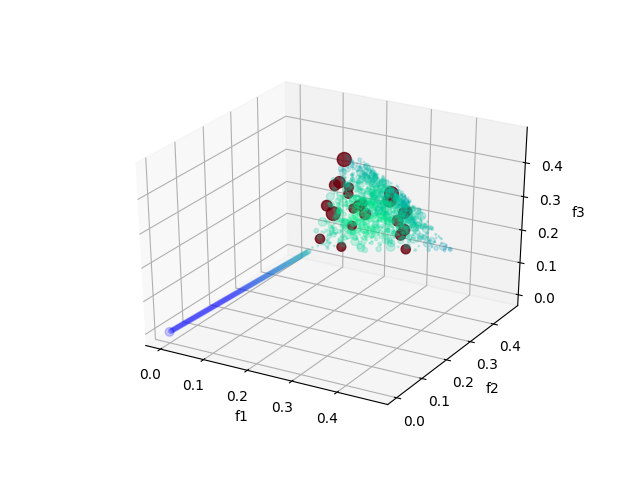

In [72]:
# use the original obj values for scatter plot.
rawpoints = fmt.load(rawfpath)
# do the scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)
# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter.pdf")
plt.savefig(scatterfpath, transparent = False)

plt.show()

In [73]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components = len(rawpoints[0]))
pca.fit(np.array(rawpoints))
# pca_score = pca.explained_variance_ratio_

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


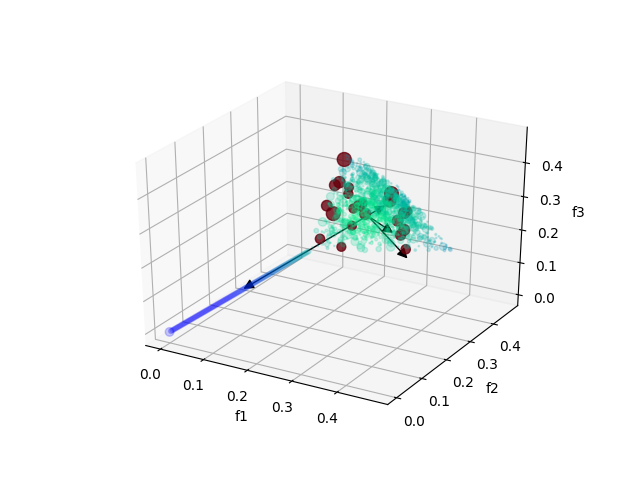

In [74]:
# Now do a scatter plot again with PCA directions
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)

for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    from_ = pca.mean_.tolist()
    to_ = (pca.mean_ + v).tolist()
    a = Arrow3D([from_[0], to_[0]], [from_[1], to_[1]], [from_[2], to_[2]], \
                mutation_scale = 15, lw = 1, arrowstyle = "-|>", color = "black")
    ax.add_artist(a)

# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter-pca.pdf")
plt.savefig(scatterfpath, transparent = False)
    
plt.show()

In [75]:
import math

u = pca.components_[0].tolist()
m = pca.mean_.tolist()
ndist = []
for p in rawpoints:
    x = [f - m[i] for i, f in enumerate(p)]
    x2 = math.fsum([v ** 2 for v in x])
    y = vops.dot(x, u)
    ndist.append(math.sqrt(x2 - y * y))
print(ndist)

[0.06963998104378476, 0.06827593675079074, 0.06691189663870292, 0.0655478609685315, 0.06418383002347894, 0.06281980411134029, 0.06145578356723578, 0.06009176875670804, 0.05872776007926616, 0.057363757972409016, 0.055999762916264385, 0.054635775438899366, 0.05327179612246219, 0.051907825610286784, 0.05054386461514205, 0.04917991392887041, 0.04781597443365138, 0.046452047115270505, 0.045088133078787465, 0.04372423356712962, 0.04236034998328838, 0.04099648391693415, 0.039632637176547456, 0.03826881182837365, 0.03690501024406318, 0.03554123515924063, 0.03417748974611824, 0.032813777704170065, 0.03145010337443548, 0.03008647188485194, 0.028722889336983713, 0.027359363048555588, 0.025995901872253275, 0.024632516620359608, 0.02326922063851907, 0.02190603059359253, 0.020542967574859464, 0.019180058664338657, 0.01781733922684686, 0.016454856336437784, 0.01509267405572822, 0.013730881851629744, 0.012369608557492268, 0.011009046665314636, 0.00964949709901131, 0.008291457846476608, 0.0069358161269

<IPython.core.display.Javascript object>


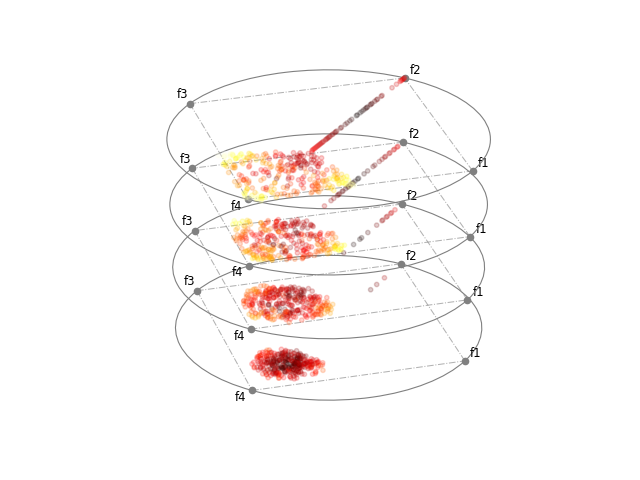

In [76]:
import matplotlib.cm as cm

[lb, ub] = vops.get_bound(ndist)
nndist = vops.normalize(ndist, lb, ub)
color = [cm.hot(d) for d in nndist]

palette_coords = fmt.load(os.path.join(path, prefix + "-norm-palette-invsc.out"))

# do the paletteviz plot
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(points[0]), \
            s = 10.0, c = color, alpha = [0.2, 0.2], camera = dcor.cam_palette[prefix], \
            knee_idx = None, mode = "sc")
# save the paletteviz plot
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
palettefpath = os.path.join(".", prefix + "-norm-palette-invsc-ndist.pdf")
plt.savefig(palettefpath, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()

<IPython.core.display.Javascript object>


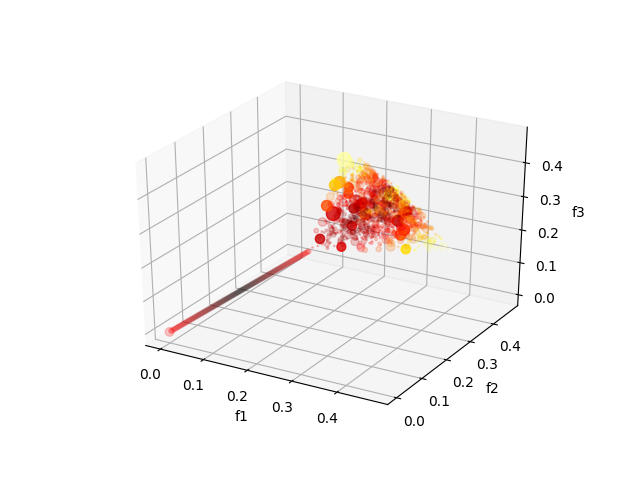

In [77]:
# do the scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)
# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter-ndist.pdf")
plt.savefig(scatterfpath, transparent = False)

plt.show()